<a href="https://colab.research.google.com/github/pabloinsente/CovNet_Human_Drawings/blob/master/code/baseline_binary_classification_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Baseline for binary classification of child/adult from drawings with PCA vectors

##Data Preparation

In [0]:
!pip install rarfile

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from imblearn.over_sampling import RandomOverSampler 
from imblearn.over_sampling import SMOTE 

import rarfile, csv

from numpy import genfromtxt
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

In [0]:
# Clone the data into Colab
! git clone https://github.com/pabloinsente/CovNet_Human_Drawings

In [16]:
# Read csv files from compressed rar file and convert into a dataframe
rar_path = rarfile.RarFile("CovNet_Human_Drawings/data/merged_dataframes_prediction/x_drawings_features_max_pool_5.rar")
csv_file_name = "x_drawings_features_max_pool_5.csv"
rar_file = rarfile.RarFile.open(rar_path, csv_file_name)
x = pd.read_csv(rar_file, sep=",", header=None)
print(x.shape)
print(x.iloc[0:5,0:5])

(258, 25088)
          0    1    2         3         4
0 -0.001317  0.0  0.0 -0.001322 -0.003181
1 -0.001052  0.0  0.0 -0.001056 -0.002540
2 -0.001176  0.0  0.0 -0.001181 -0.002840
3 -0.000836  0.0  0.0 -0.000839 -0.000957
4 -0.001163  0.0  0.0 -0.001168  0.011156


In [17]:
# Read labels vector
y_path = 'CovNet_Human_Drawings/data/merged_dataframes_prediction/y_age_adult_labels.csv'
y = genfromtxt(y_path, delimiter=',')

#x = x.drop([0]) # drop headers
print(y.shape)
print(y[0:5])

(258,)
[0. 0. 0. 0. 0.]


##PCA

In [0]:
from sklearn.decomposition import PCA
import numpy as np

Text(0, 0.5, 'Cumulative explained variance')

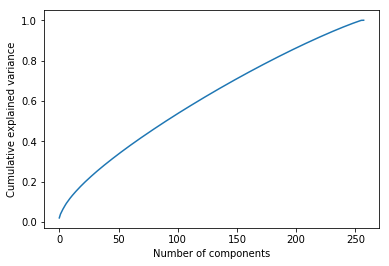

In [19]:
# Let's print out the accumulated explained variance as we get
# more components using PCA 

pca = PCA(n_components=x.shape[0])
pca.fit(x)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [20]:
NCOMPONENTS = 200

pca = PCA(n_components=NCOMPONENTS)
x_pca = pca.fit_transform(x)
x = x_pca
x.shape

(258, 200)

In [22]:
# Split data into train and test sets
# Since we have an small sample, we will do a 70/30 split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=44, stratify=y)
print(x_train.shape) 
print(y_train.shape) 
print(x_test.shape) 
print(y_test.shape)

(180, 200)
(180,)
(78, 200)
(78,)


##Resampling Imbalanced Data
Since our classes are imbalanced, we will use oversampling of the "adult" class **on the training set**  to help training on that class. *imblearn* implement oversampling for us

**See documentantion at** https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.RandomOverSampler.html

In [23]:
#ros = RandomOverSampler(random_state=42)
ros = SMOTE(random_state=42)

x_train_res, y_train_res = ros.fit_resample(x_train, y_train)
print(x_train_res.shape) # (258, 200)
print(y_train_res.shape) # (258,)
print('Resampled dataset shape %s' % Counter(y_train_res))

# Now we have 50/50 balanced classes

(290, 200)
(290,)
Resampled dataset shape Counter({0.0: 145, 1.0: 145})


Resampled dataset shape Counter({0.0: 145, 1.0: 145})


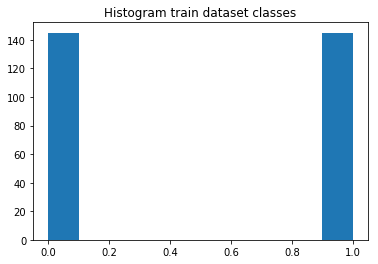

In [24]:
x_train = x_train_res
y_train = y_train_res
print('Resampled dataset shape %s' % Counter(y_train))
plt.hist(y_train, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram train dataset classes")
plt.show()

Test dataset shape Counter({0.0: 63, 1.0: 15})


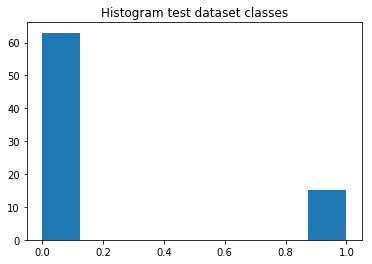

In [25]:
print('Test dataset shape %s' % Counter(y_test))
plt.hist(y_test, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram test dataset classes")
plt.show()

## Train and test machine learning classifiers

In [0]:
# Import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from scipy.stats import norm

# Import models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

import math
import pandas as pd

In [0]:
# Lists to store values
# List of performance measures to evaluate models (criteria list)
# List of labels to create dataframe

# Confusion matrix values as frequency
true_neg_l = []
false_pos_l = []
false_neg_l = []
true_pos_l = []

# Confusion matrix values as percentage
true_neg_per_l = []
false_pos_per_l = []
false_neg_per_l = []
true_pos_per_l = []

# Other metrics for all
hit_rate_l = []
false_alarm_rate_l = []
d_sensitivity_l = []
c_bias_l = []
accuracy_score_l = []

# List to append model name
model_l= []

# Function that receives the model name, training and testing dataset, and appends values to lists
def classification_report(model, x_train, y_train, x_test, y_test, random_state = 0):
  
  # Get model name and append
  model_n = str(model)
  model_n = model_n.split('(')[0]
  model_l.append(model_n)
  
  # pass model to classifier
  classifier = model
  # train model
  classifier.fit(x_train, y_train)

  # test model on test set
  y_pred = classifier.predict(x_test)
  y_true = y_test 

  # Extract confusion matrix values
  true_neg, false_pos, false_neg, true_pos = confusion_matrix(y_true, y_pred).ravel()
  true_neg_l.append(true_neg)
  false_pos_l.append(false_pos)
  false_neg_l.append(false_neg)
  true_pos_l.append(true_pos)

  # Compute confusion matrix as percentage
  all_negatives = true_neg + false_pos
  all_positives = false_neg + true_pos
  true_neg_per = true_neg / all_negatives
  true_neg_per_l.append(true_neg_per)
  false_pos_per = false_pos / all_negatives
  false_pos_per_l.append(false_pos_per)
  false_neg_per = false_neg / all_positives
  false_neg_per_l.append(false_neg_per)
  true_pos_per = true_pos / all_positives
  true_pos_per_l.append(true_pos_per)
  
  
  # Floors an ceilings are replaced by half hits and half FA's
  half_hit = 0.5 / (true_pos + false_neg)
  half_fa = 0.5 / (false_pos + true_neg)
  
  # Compute Hit rate and avoid d' infinity
  hit_rate = true_pos / (true_pos + false_neg)
  if hit_rate == 1: 
    hit_rate = 1 - half_hit
  if hit_rate == 0: 
    hit_rate = half_hit
  
  hit_rate_l.append(hit_rate)
  
  # Compute False alarm rate and avoid d' infinity
  false_alarm_rate = false_pos / (false_pos + true_neg)
  if false_alarm_rate == 1: 
      false_alarm_rate = 1 - half_fa
  if false_alarm_rate == 0: 
      false_alarm_rate = half_fa
  false_alarm_rate_l.append(false_alarm_rate) 
  
  # get z-score
  Z = norm.ppf
  
  # Compute Sensitivity - d'
  d_sensitivity = Z(hit_rate) - Z(false_alarm_rate)
  d_sensitivity_l.append(d_sensitivity)
  
  # Compute Bias - c
  c_bias = -(Z(hit_rate) + Z(false_alarm_rate)) / 2
  c_bias_l.append(c_bias)
  
  # Compute test accuracy
  acc = accuracy_score(y_true, y_pred)
  accuracy_score_l.append(acc)

In [48]:
# Define and train models to get classification report by calling "classification_report" function

log_classifier  =  LogisticRegression()
svm =  SVC(gamma='auto')
d_tree  =  tree.DecisionTreeClassifier()
g_bayes =  GaussianNB()
r_forest =  RandomForestClassifier(n_estimators=100)
g_boosting =  GradientBoostingClassifier(n_estimators=100, learning_rate = 0.1)

classification_report(log_classifier, x_train, y_train, x_test, y_test)
classification_report(svm, x_train, y_train, x_test, y_test)
classification_report(d_tree, x_train, y_train, x_test, y_test)
classification_report(g_bayes, x_train, y_train, x_test, y_test)
classification_report(r_forest, x_train, y_train, x_test, y_test)
classification_report(g_boosting, x_train, y_train, x_test, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [49]:
# Build classification report dataframe 

# Labels to build dataframe
labels = ["Model","True_Negatives", "False_Positives", "False_Negatives", "True_Positives",
          "True_Negatives_Per", "False_Positives_Per", "False_Negatives_Per", "True_Positives_Per",
          "Hit_Rate", "False_Alarm_Rate", "d_sensitivity", "c_bias", "Test_Accuracy_Score"]

data = list(zip(model_l, true_neg_l, false_pos_l, false_neg_l, true_pos_l,
                true_neg_per_l, false_pos_per_l, false_neg_per_l,true_pos_per_l,
                hit_rate_l,false_alarm_rate_l, d_sensitivity_l, c_bias_l, 
                accuracy_score_l))

assert len(model_l) == len(data), "criteria list and data don't match"

classification_report = pd.DataFrame(data, columns=labels, index = None )

# Now we can look the report in one place
classification_report 

,Model,True_Negatives,False_Positives,False_Negatives,True_Positives,True_Negatives_Per,False_Positives_Per,False_Negatives_Per,True_Positives_Per,Hit_Rate,False_Alarm_Rate,d_sensitivity,c_bias,Test_Accuracy_Score
0,LogisticRegression,60,3,14,1,0.952381,0.047619,0.933333,0.066667,0.066667,0.047619,0.167305,1.584739,0.782051
1,SVC,62,1,15,0,0.984127,0.015873,1.000000,0.000000,0.033333,0.015873,0.313679,1.990754,0.794872
2,DecisionTreeClassifier,50,13,13,2,0.793651,0.206349,0.866667,0.133333,0.133333,0.206349,-0.291617,0.964963,0.666667
3,GaussianNB,55,8,14,1,0.873016,0.126984,0.933333,0.066667,0.066667,0.126984,-0.360322,1.320925,0.717949
4,RandomForestClassifier,63,0,15,0,1.000000,0.000000,1.000000,0.000000,0.033333,0.007937,0.577908,2.122868,0.807692
5,GradientBoostingClassifier,58,5,15,0,0.920635,0.079365,1.000000,0.000000,0.033333,0.079365,-0.424559,1.621635,0.743590


In [0]:
# save report on a csv file
exp_n = 'ml_classifiers'
file_name = 'classification_report_dap_' + exp_n + '.csv'
classification_report.to_csv(file_name, sep=',')

## Plot results

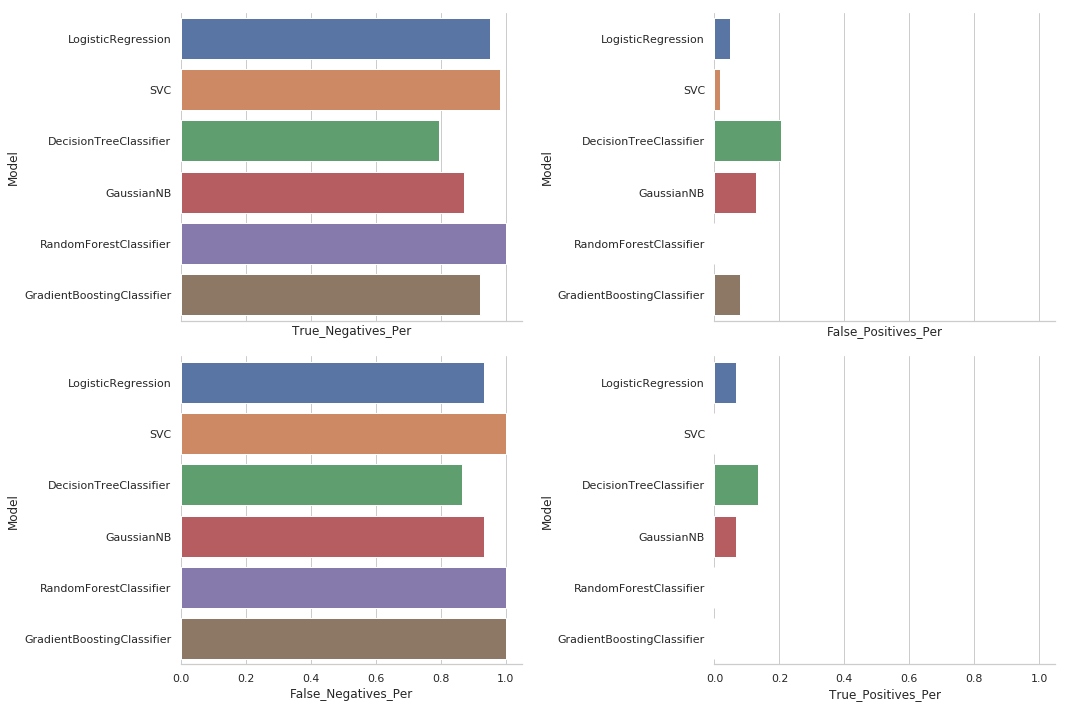

In [50]:
import seaborn as sns
sns.set(style="whitegrid")

f, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True)
sns.despine(left=True)

sns.barplot(x="True_Negatives_Per", y= "Model", data=classification_report, ax=axes[0, 0])
sns.barplot(x="False_Positives_Per", y= "Model", data=classification_report, ax=axes[0, 1])
sns.barplot(x="False_Negatives_Per", y= "Model", data=classification_report, ax=axes[1, 0])
sns.barplot(x="True_Positives_Per", y= "Model", data=classification_report, ax=axes[1, 1])


plt.tight_layout()
plt.savefig('confusion_matrix_classifiers.pdf')

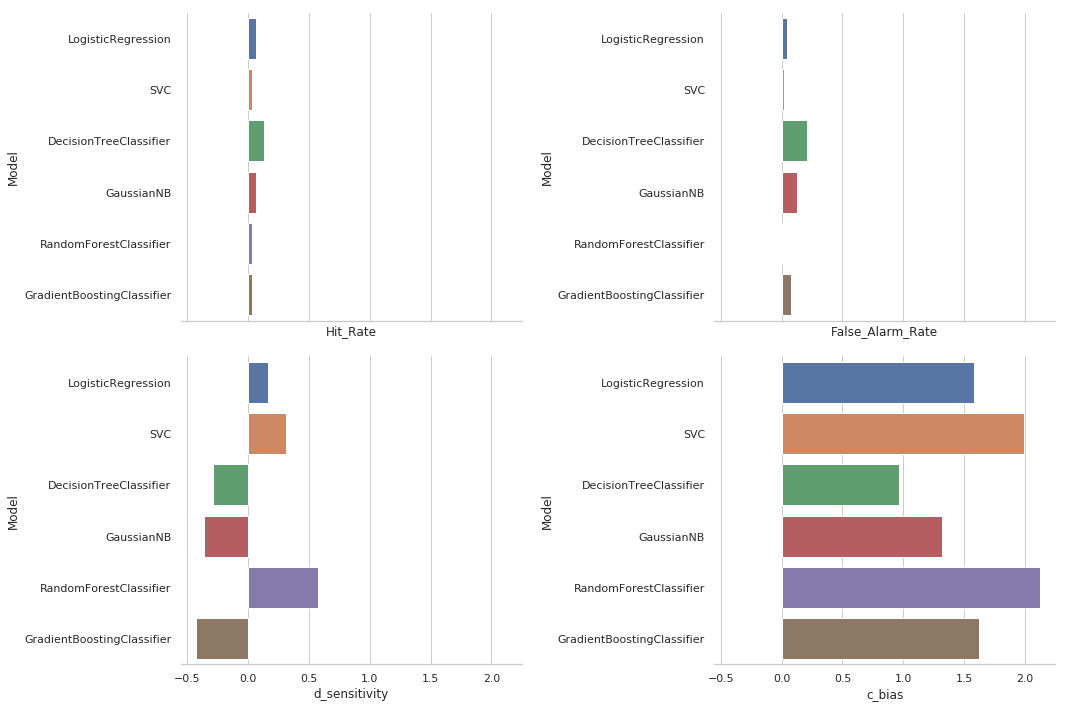

In [51]:
sns.set(style="whitegrid")

f, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True)
sns.despine(left=True)

sns.barplot(x="Hit_Rate", y= "Model", data=classification_report, ax=axes[0, 0])
sns.barplot(x="False_Alarm_Rate", y= "Model", data=classification_report, ax=axes[0, 1])
sns.barplot(x="d_sensitivity", y= "Model", data=classification_report, ax=axes[1, 0])
sns.barplot(x="c_bias", y= "Model", data=classification_report, ax=axes[1, 1])

plt.tight_layout()
plt.savefig('signal_detection_report_classifiers.pdf')

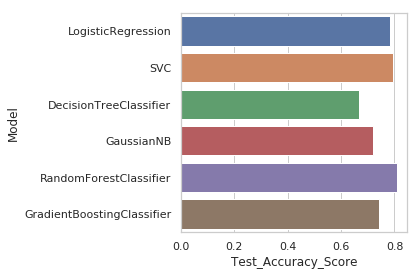

In [55]:
sns.set(style="whitegrid")

#f, axes = plt.subplots(ncols=2, figsize=(15, 10), sharex=True)
sns.despine(left=True)

sns.barplot(x="Test_Accuracy_Score", y= "Model", data=classification_report)

plt.tight_layout()
plt.savefig('test_accuracy_classifiers.pdf')